In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

character(0)

In [ ]:
### Para el modelado
library(earth)
library(mgcv)
library(caret)     # para optimizar proceso de tunning

#Otros de manipulación de datos
library(tseries)  #manipulación series de tiempo
library(tsfeatures) # Obtención de features relevantes
library(tidyverse) #Data manipulation
library(fields)  #Data manipulation
library(forecast)  # para función pronosticos
library(quantmod) #Para obtener datos financiera
library(dygraphs)  # data visualization
library(dplyr)    # data wrangling
library(ggplot2)  # gráficos
theme_set(theme_bw())
options(warn = - 1)

In [ ]:
# Descargar la información de META
start_str = "2016-05-01"
end_str = "2018-01-28"
start<-format(as.Date(start_str),"%Y-%m-%d")
end<-format(as.Date(end_str),"%Y-%m-%d")

precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre 4:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}
precios("META")
META

           META.Close
2016-05-02     118.57
2016-05-03     117.43
2016-05-04     118.06
2016-05-05     117.81
2016-05-06     119.49
2016-05-09     119.24
2016-05-10     120.50
2016-05-11     119.52
2016-05-12     120.28
2016-05-13     119.81
       ...           
2018-01-12     179.37
2018-01-16     178.39
2018-01-17     177.60
2018-01-18     179.80
2018-01-19     181.29
2018-01-22     185.37
2018-01-23     189.35
2018-01-24     186.55
2018-01-25     187.48
2018-01-26     190.00

In [ ]:
# Garficar la serie

Pr<-merge.xts(META) %>% na.omit()
head(Pr)
colnames(Pr) <- c("Meta")
head(Pr)
##Serie tiempo, grafica interactiva
Precios<- dygraph(Pr[,c(1)], main="Precios ") %>%
  dyAxis("y", label = "Precios") %>%
  dyRangeSelector(dateWindow = c(start_str, end_str))%>%
  dyOptions(colors = RColorBrewer::brewer.pal(4,"Set1"))
Precios

           META.Close
2016-05-02     118.57
2016-05-03     117.43
2016-05-04     118.06
2016-05-05     117.81
2016-05-06     119.49
2016-05-09     119.24

             Meta
2016-05-02 118.57
2016-05-03 117.43
2016-05-04 118.06
2016-05-05 117.81
2016-05-06 119.49
2016-05-09 119.24

HTML widgets cannot be represented in plain text (need html)

In [ ]:
# Formatear los datos a una serie de tiempo, cambiar al formato zoo

xpr <- as.xts(Pr, dateFormat = "Date")
Pr_index <- fortify.zoo(xpr)
head(Pr_index)
nrow(Pr)


,Index,Meta
,<date>,<dbl>
1,2016-05-02,118.57
2,2016-05-03,117.43
3,2016-05-04,118.06
4,2016-05-05,117.81
5,2016-05-06,119.49
6,2016-05-09,119.24


[1] 439

In [ ]:
#Partimos serie para train & test
h <- round(length(Pr)*0.05, digits = 0 )
h
Pr_tra <- Pr[1:(nrow(Pr) - h), ]
Pr_tes<- Pr[(nrow(Pr) - h + 1):nrow(Pr), ]

[1] 22

# Modelo MARS

In [ ]:
#Pasamos a formato data frame para poder generar los retrasos
Pr_df_tra<-as.data.frame(Pr_tra)
head(Pr_df_tra)
str(Pr_df_tra)

,Meta
,<dbl>
2016-05-02,118.57
2016-05-03,117.43
2016-05-04,118.06
2016-05-05,117.81
2016-05-06,119.49
2016-05-09,119.24


'data.frame':	417 obs. of  1 variable:
 $ Meta: num  119 117 118 118 119 ...


frequency,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,entropy,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0.9901344,1.737658e-09,19.22551,4.38829,0.7349023,1.041272,0.09337241,0.9927452,9.236512,-0.01550977,0.03439839,-0.4949165,0.2821558


x_pacf5 diff1x_pacf5 diff2x_pacf5 
  0.98585140   0.01221966   0.48969533

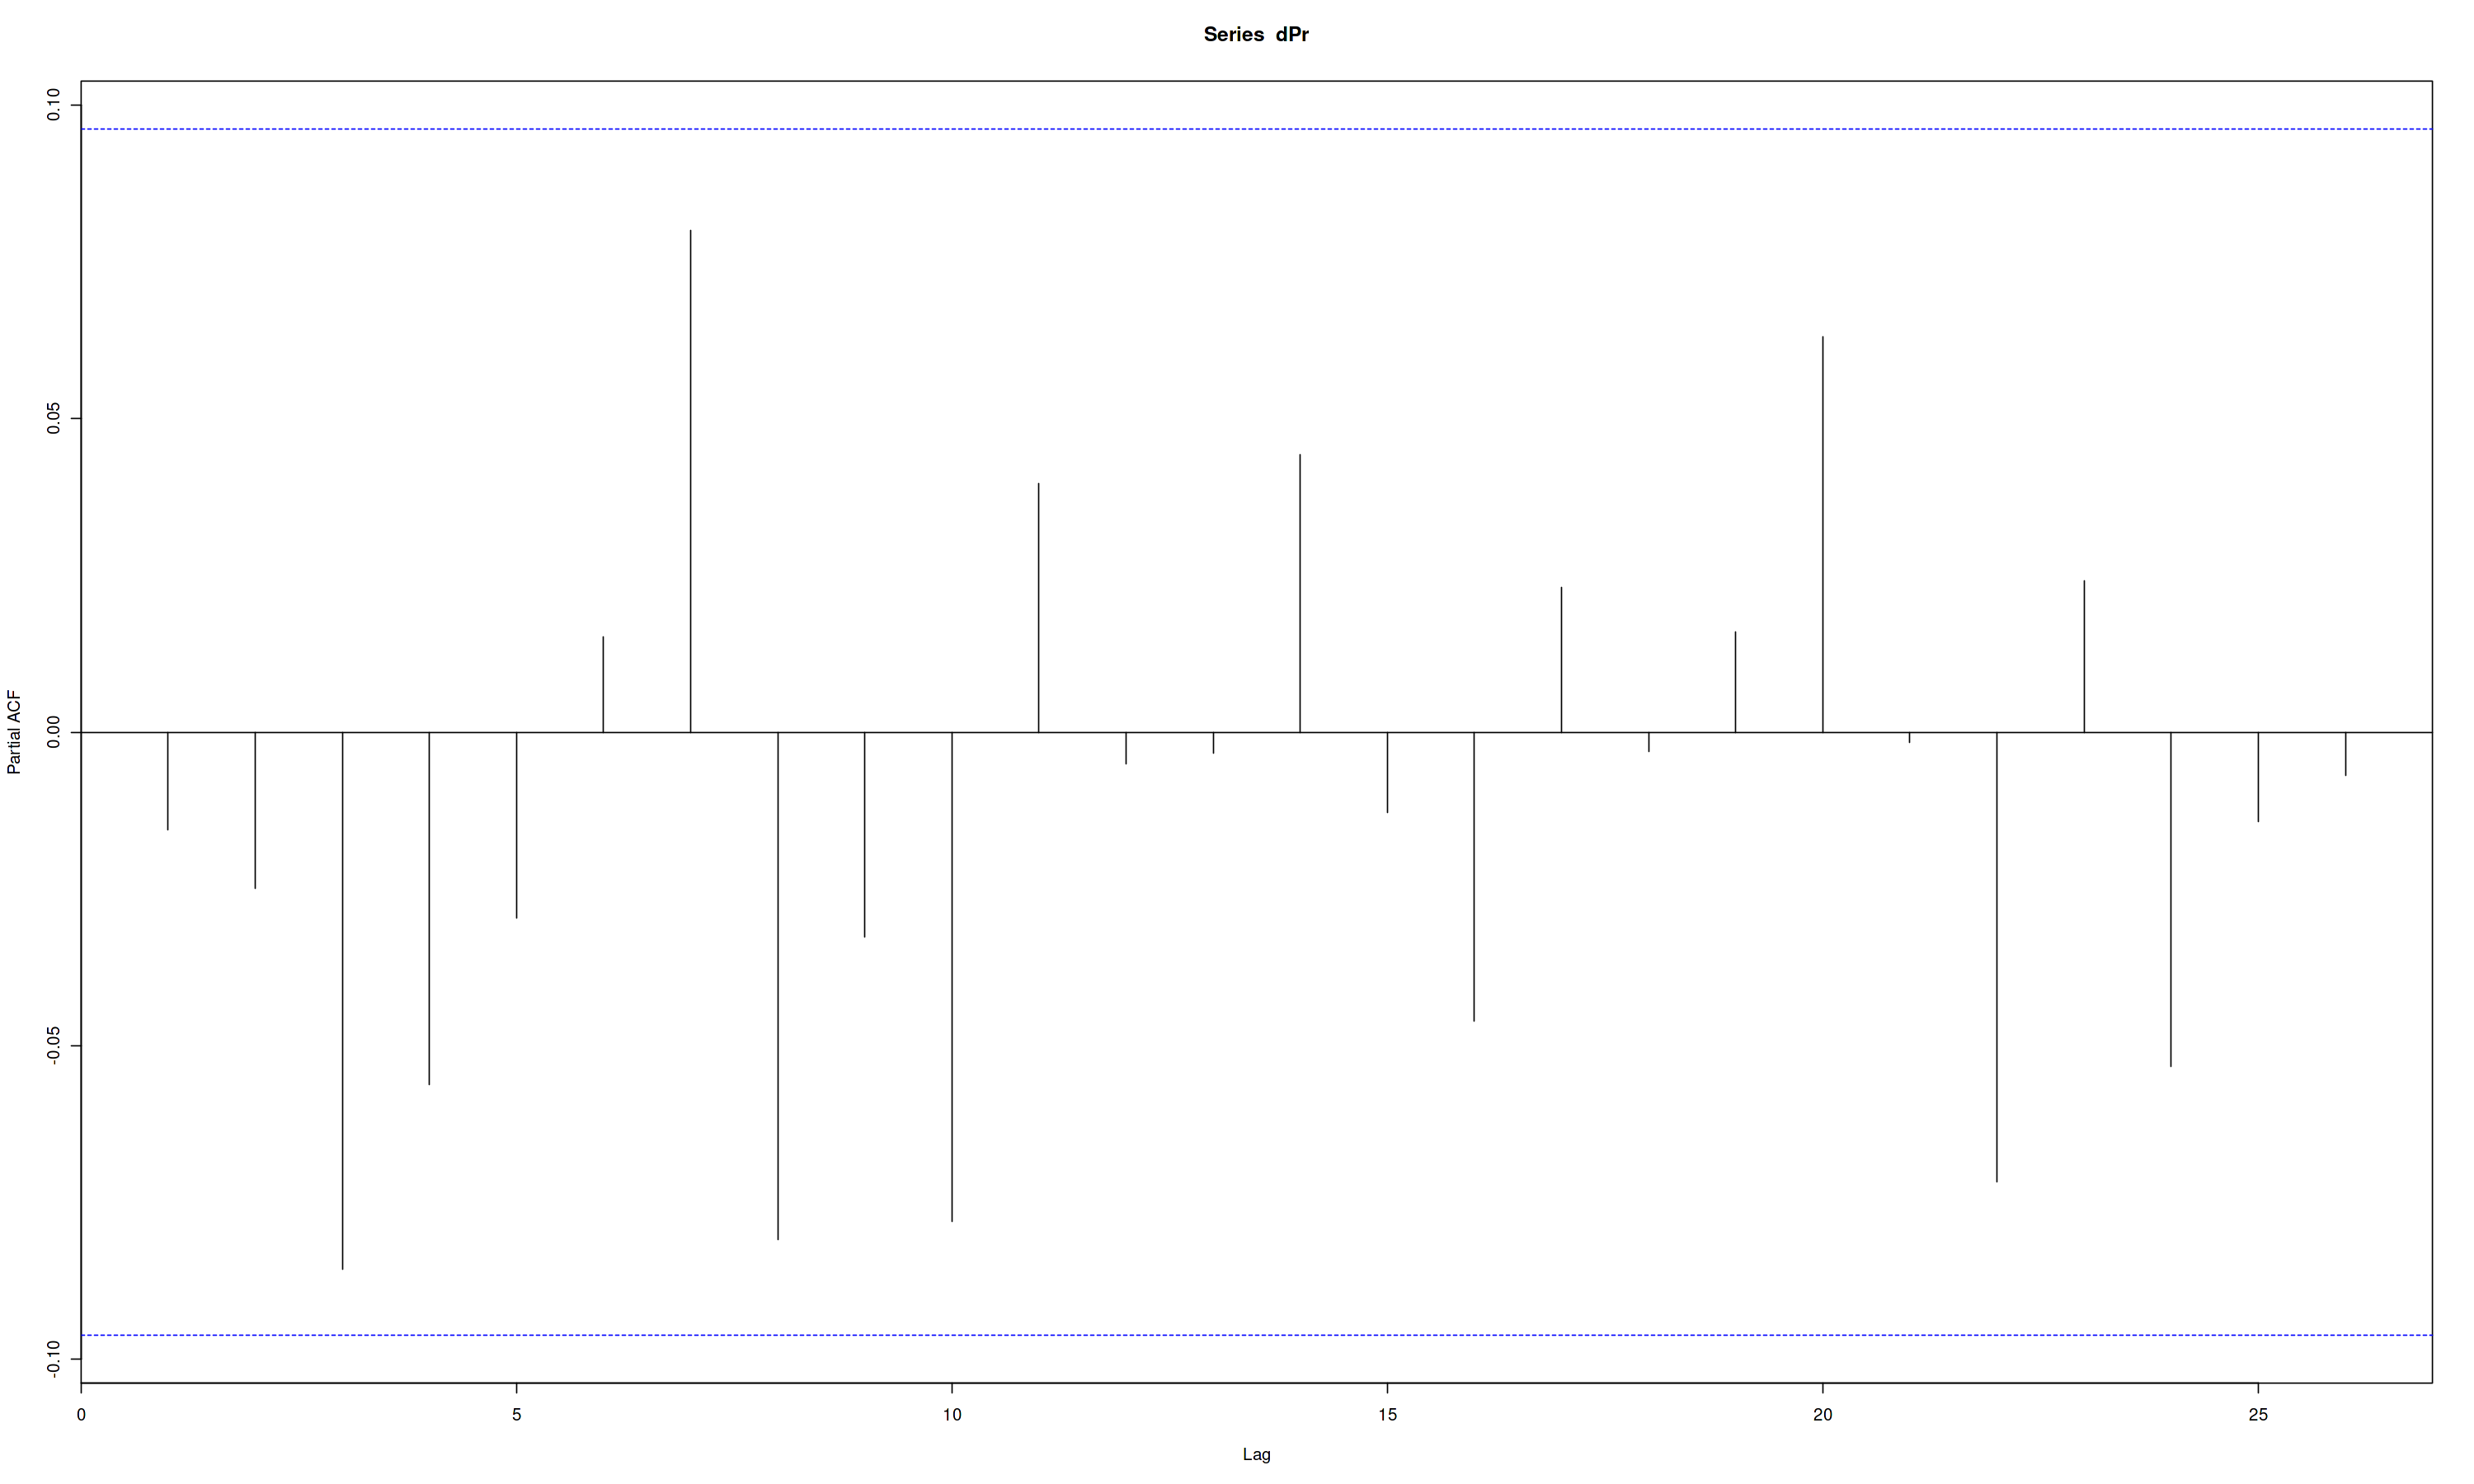

In [ ]:
#Obteneomos features:
tsfeatures(Pr_df_tra$Meta)
pacf_features(Pr_df_tra$Meta)
#Visualiamos los rezagos autorregresivos, haciendo estacionaria la serie:
dPr<-diff(Pr_df_tra$Meta)%>% na.omit() # Train section.
pacf(dPr)

In [ ]:
#Generamos retrasos
Pr_df_tra<-as.data.frame(Pr_tra)

lag_pr = lag(Pr_df_tra,n=1L)
lag2_pr = lag(Pr_df_tra,n=2L)
lag3_pr = lag(Pr_df_tra,n=3L)
lag4_pr = lag(Pr_df_tra,n=4L)
lag5_pr = lag(Pr_df_tra,n=5L)

#Unimos los nuevos features o retrasos en una base
Pr_all_train<-cbind(Pr_df_tra, lag_pr, lag2_pr, lag3_pr, lag4_pr,lag5_pr) %>%na.omit()
colnames(Pr_all_train)<-c("Meta","l1","l2","l3","l4","l5")
Pr_all_train$trend = 1:nrow(Pr_all_train)

mars_mod <- earth(
  Meta ~ ., data=Pr_all_train, pmethod="backward" )


In [ ]:
# Podemos ver el resultado del modelo:
print(mars_mod)

Selected 2 of 3 terms, and 1 of 6 predictors
Termination condition: RSq changed by less than 0.001 at 3 terms
Importance: l1, l2-unused, l3-unused, l4-unused, l5-unused, trend-unused
Number of terms at each degree of interaction: 1 1 (additive model)
GCV 2.579219    RSS 1047.219    GRSq 0.9945824    RSq 0.994635


In [ ]:
summary(mars_mod)

Call: earth(formula=Meta~., data=Pr_all_train, pmethod="backward")

             coefficients
(Intercept)    180.309871
h(180.06-l1)    -1.001975

Selected 2 of 3 terms, and 1 of 6 predictors
Termination condition: RSq changed by less than 0.001 at 3 terms
Importance: l1, l2-unused, l3-unused, l4-unused, l5-unused, trend-unused
Number of terms at each degree of interaction: 1 1 (additive model)
GCV 2.579219    RSS 1047.219    GRSq 0.9945824    RSq 0.994635

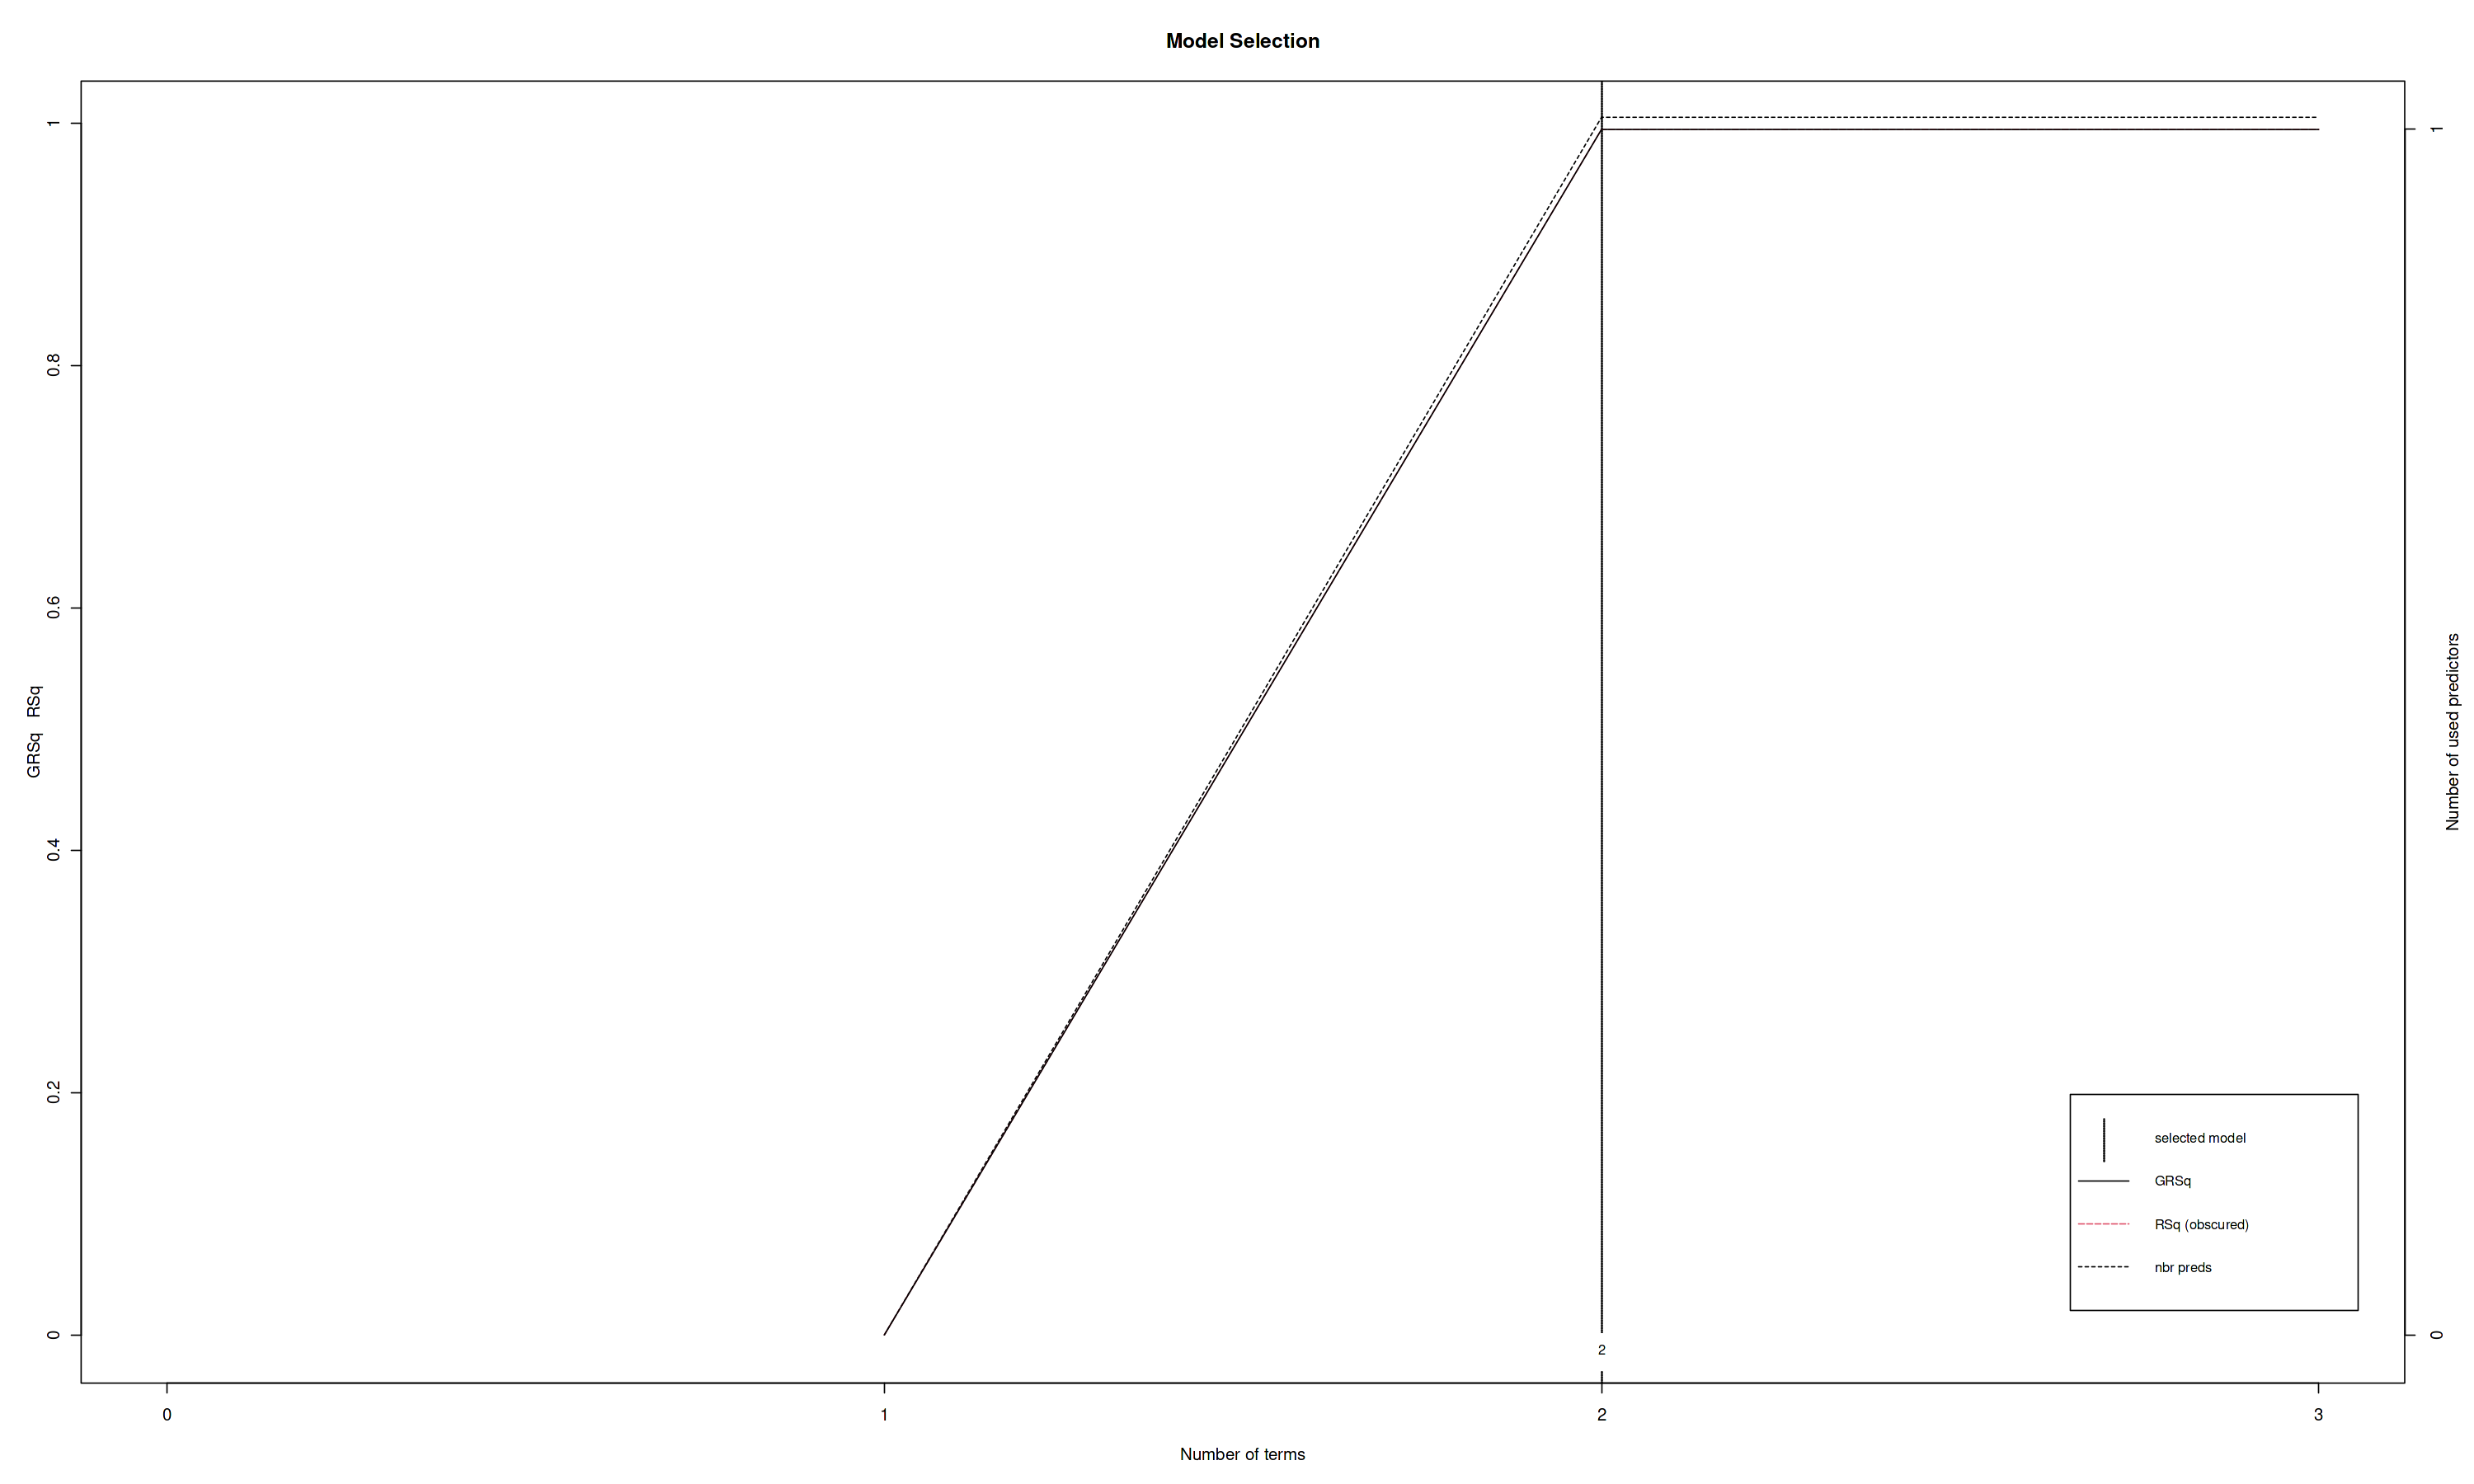

In [ ]:
plot(mars_mod, which = 1)


In [ ]:
#Procedemos con pasar los datos de un formato xts, a un formato data.frame para facilitar la generación de rezagos.
Pr_test2<-as.data.frame(Pr_tes)
#head(Pr_test2)
Pr_test2
#Generación de rezagos o features: debemos generar los mismos tipos de features que en la parte de entrenamiento.
lag1_pr_test = lag(Pr_test2,n=1L)
lag2_pr_test = lag(Pr_test2,n=2L)
lag3_pr_test = lag(Pr_test2,n=3L)
lag4_pr_test = lag(Pr_test2,n=4L)
lag5_pr_test = lag(Pr_test2,n=5L)

Pr_all_test<-cbind(Pr_test2, lag1_pr_test, lag2_pr_test, lag3_pr_test, lag4_pr_test,lag5_pr_test) %>%na.omit()
colnames(Pr_all_test)<-c("Meta","l1","l2","l3","l4","l5")
#Generamos la tendencia:
Pr_all_test$trend = 1:nrow(Pr_all_test)
#Renombramos:
colnames(Pr_all_test)<-c("Meta","l1","l2","l3","l4", "l5","trend")
dim(Pr_all_test)
head(Pr_all_test)
str(Pr_all_test)


,Meta
,<dbl>
2017-12-26,175.99
2017-12-27,177.62
2017-12-28,177.92
2017-12-29,176.46
2018-01-02,181.42
2018-01-03,184.67
2018-01-04,184.33
2018-01-05,186.85
2018-01-08,188.28


[1] 17  7

,Meta,l1,l2,l3,l4,l5,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2018-01-03,184.67,181.42,176.46,177.92,177.62,175.99,1
2018-01-04,184.33,184.67,181.42,176.46,177.92,177.62,2
2018-01-05,186.85,184.33,184.67,181.42,176.46,177.92,3
2018-01-08,188.28,186.85,184.33,184.67,181.42,176.46,4
2018-01-09,187.87,188.28,186.85,184.33,184.67,181.42,5
2018-01-10,187.84,187.87,188.28,186.85,184.33,184.67,6


'data.frame':	17 obs. of  7 variables:
 $ Meta : num  185 184 187 188 188 ...
 $ l1   : num  181 185 184 187 188 ...
 $ l2   : num  176 181 185 184 187 ...
 $ l3   : num  178 176 181 185 184 ...
 $ l4   : num  178 178 176 181 185 ...
 $ l5   : num  176 178 178 176 181 ...
 $ trend: int  1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "na.action")= 'omit' Named int [1:5] 1 2 3 4 5
  ..- attr(*, "names")= chr [1:5] "2017-12-26" "2017-12-27" "2017-12-28" "2017-12-29" ...


In [ ]:
yt <- as.xts(Pr_all_test, dateFormat = "Date")
Pr_test2 <- fortify.zoo(yt)
Pr_test2

Index,Meta,l1,l2,l3,l4,l5,trend
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-03,184.67,181.42,176.46,177.92,177.62,175.99,1
2018-01-04,184.33,184.67,181.42,176.46,177.92,177.62,2
2018-01-05,186.85,184.33,184.67,181.42,176.46,177.92,3
2018-01-08,188.28,186.85,184.33,184.67,181.42,176.46,4
2018-01-09,187.87,188.28,186.85,184.33,184.67,181.42,5
2018-01-10,187.84,187.87,188.28,186.85,184.33,184.67,6
2018-01-11,187.77,187.84,187.87,188.28,186.85,184.33,7
2018-01-12,179.37,187.77,187.84,187.87,188.28,186.85,8
2018-01-16,178.39,179.37,187.77,187.84,187.87,188.28,9


In [ ]:
x_test <- Pr_test2 %>%
  select(starts_with(c("l", "t")))
head(x_test)


,l1,l2,l3,l4,l5,trend
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,181.42,176.46,177.92,177.62,175.99,1
2,184.67,181.42,176.46,177.92,177.62,2
3,184.33,184.67,181.42,176.46,177.92,3
4,186.85,184.33,184.67,181.42,176.46,4
5,188.28,186.85,184.33,184.67,181.42,5
6,187.87,188.28,186.85,184.33,184.67,6


In [ ]:
y_test <- Pr_test2%>%
  select(Meta)
#y_test$Index <- Pr_test2$Index
#y_test

In [ ]:
pred_mars = predict(mars_mod, x_test)[,1]
pred_mars


[1] 180.3099 180.3099 180.3099 180.3099 180.3099 180.3099 180.3099 180.3099
 [9] 179.6185 178.6366 177.8450 180.0494 180.3099 180.3099 180.3099 180.3099
[17] 180.3099

In [ ]:
# Resultados SSA
SSA = c(182.29770843655,
  182.214668520943,
  182.017723640158,
  181.737481946605,
  181.416775140506,
  181.107978895596,
  180.864528433611,
  180.73560204297,
  180.761528040455,
  180.968710804232,
  181.368079962488,
  181.953061932452,
  182.699969493438,
  183.5687456452,
  184.509098272568,
  185.463408692024,
  186.375764260098,
  187.195369834659,
  187.879891322014,
  188.406368812564,
  188.766145346507,
  188.967132496719
)
data_df<-as.data.frame(Pr_tes)
#head(Pr_test2)
data_df$PredSSA <- SSA


In [ ]:
yardstick::metrics(data_df, truth = Meta, estimate = PredSSA)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.78038401
rsq,standard,0.06727353
mae,standard,4.26223511


In [ ]:
RF <- c(177.5766859,
177.6659542,
178.474349,
179.2828157,
179.3400319,
179.3400319,
179.3233671,
179.3233671,
179.3233671,
179.3233671,
179.3233671,
179.2986387,
179.2516738,
179.2516738,
179.2516738,
179.2516738,
179.2516738,
179.2516738,
179.2516738,
179.2516738,
179.2516738,
179.2516738)

In [ ]:
data_df$PredRF <- RF
data_df <- as.xts(data_df, dateFormat = "Date")



In [ ]:
data_df_ts <- fortify.zoo(data_df)
data_df_ts

Index,Meta,PredSSA,PredRF
<date>,<dbl>,<dbl>,<dbl>
2017-12-26,175.99,182.2977,177.5767
2017-12-27,177.62,182.2147,177.6660
2017-12-28,177.92,182.0177,178.4743
2017-12-29,176.46,181.7375,179.2828
2018-01-02,181.42,181.4168,179.3400
2018-01-03,184.67,181.1080,179.3400
2018-01-04,184.33,180.8645,179.3234
2018-01-05,186.85,180.7356,179.3234
2018-01-08,188.28,180.7615,179.3234


In [ ]:
yardstick::metrics(data_df_ts, truth = Meta, estimate = PredRF)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.0552655
rsq,standard,0.2789374
mae,standard,4.8706456


In [ ]:
LSTM <- c(183.9745789,
185.6533203,
186.7079163,
187.0923309,
187.078186,
186.5314941,
185.9906006,
185.4416351,
184.97435,
184.7953796,
184.608902,
184.6670532,
NA,
NA,
NA,
NA,
NA,
NA,
NA,
NA,
NA,
NA
)

data_LSTM<-as.data.frame(Pr_tes)
#head(Pr_test2)
data_LSTM$PredLSTM <- LSTM
data_LSTM <- na.omit(data_LSTM)
data_LSTM

data_data_LSTM_df <- as.xts(data_LSTM, dateFormat = "Date")
data_data_LSTM_df_ts <- fortify.zoo(data_data_LSTM_df)
data_data_LSTM_df_ts


,Meta,PredLSTM
,<dbl>,<dbl>
2017-12-26,175.99,183.9746
2017-12-27,177.62,185.6533
2017-12-28,177.92,186.7079
2017-12-29,176.46,187.0923
2018-01-02,181.42,187.0782
2018-01-03,184.67,186.5315
2018-01-04,184.33,185.9906
2018-01-05,186.85,185.4416
2018-01-08,188.28,184.9743


Index,Meta,PredLSTM
<date>,<dbl>,<dbl>
2017-12-26,175.99,183.9746
2017-12-27,177.62,185.6533
2017-12-28,177.92,186.7079
2017-12-29,176.46,187.0923
2018-01-02,181.42,187.0782
2018-01-03,184.67,186.5315
2018-01-04,184.33,185.9906
2018-01-05,186.85,185.4416
2018-01-08,188.28,184.9743


In [ ]:
yardstick::metrics(data_LSTM, truth = Meta, estimate = PredLSTM)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.7679557
rsq,standard,0.1441162
mae,standard,4.8950920


In [ ]:
y_test$PredMars <- pred_mars
y_test$Index <- Pr_test2$Index


y_test

Meta,PredMars,Index
<dbl>,<dbl>,<date>
184.67,180.3099,2018-01-03
184.33,180.3099,2018-01-04
186.85,180.3099,2018-01-05
188.28,180.3099,2018-01-08
187.87,180.3099,2018-01-09
187.84,180.3099,2018-01-10
187.77,180.3099,2018-01-11
179.37,180.3099,2018-01-12
178.39,179.6185,2018-01-16


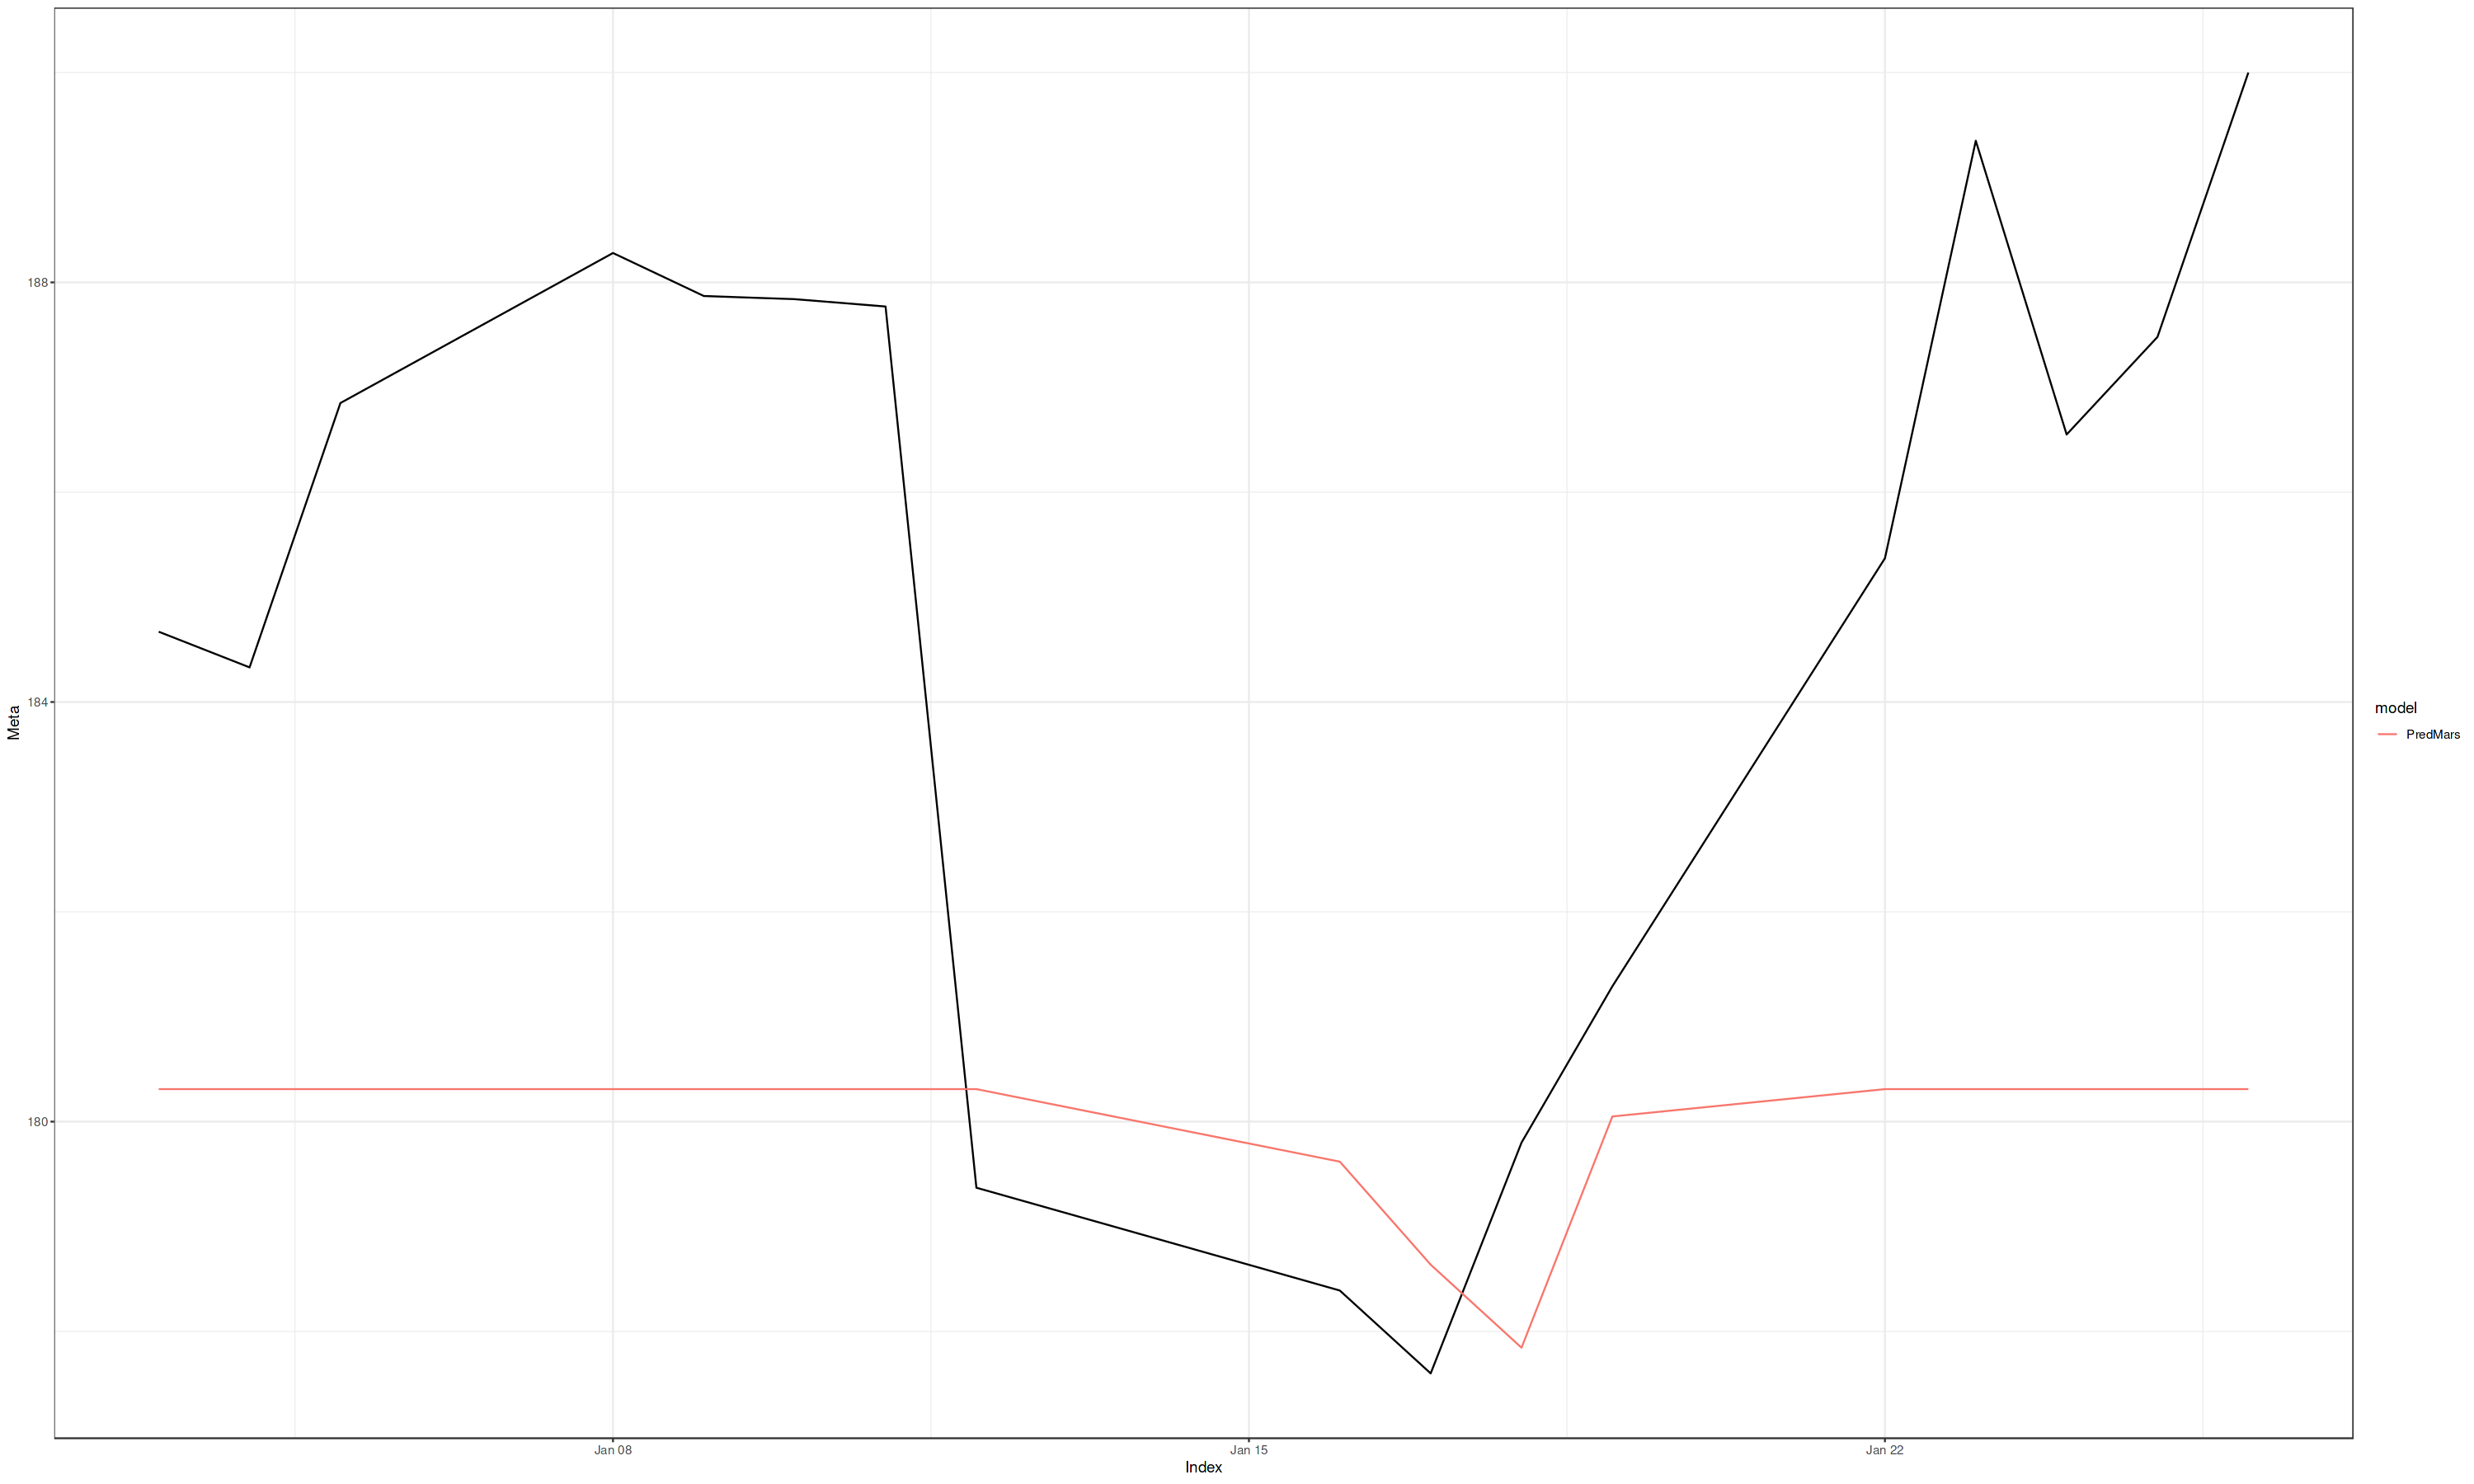

In [ ]:
y_test %>%
  select(Index, Meta, starts_with("pred")) %>%
  gather("model", "forecast", -Index, -Meta) %>%
  mutate(model = str_remove(model, "pred_")) %>%
  ggplot(aes(Index, Meta)) +
  geom_line() +
  geom_line(aes(y = forecast, color = model))

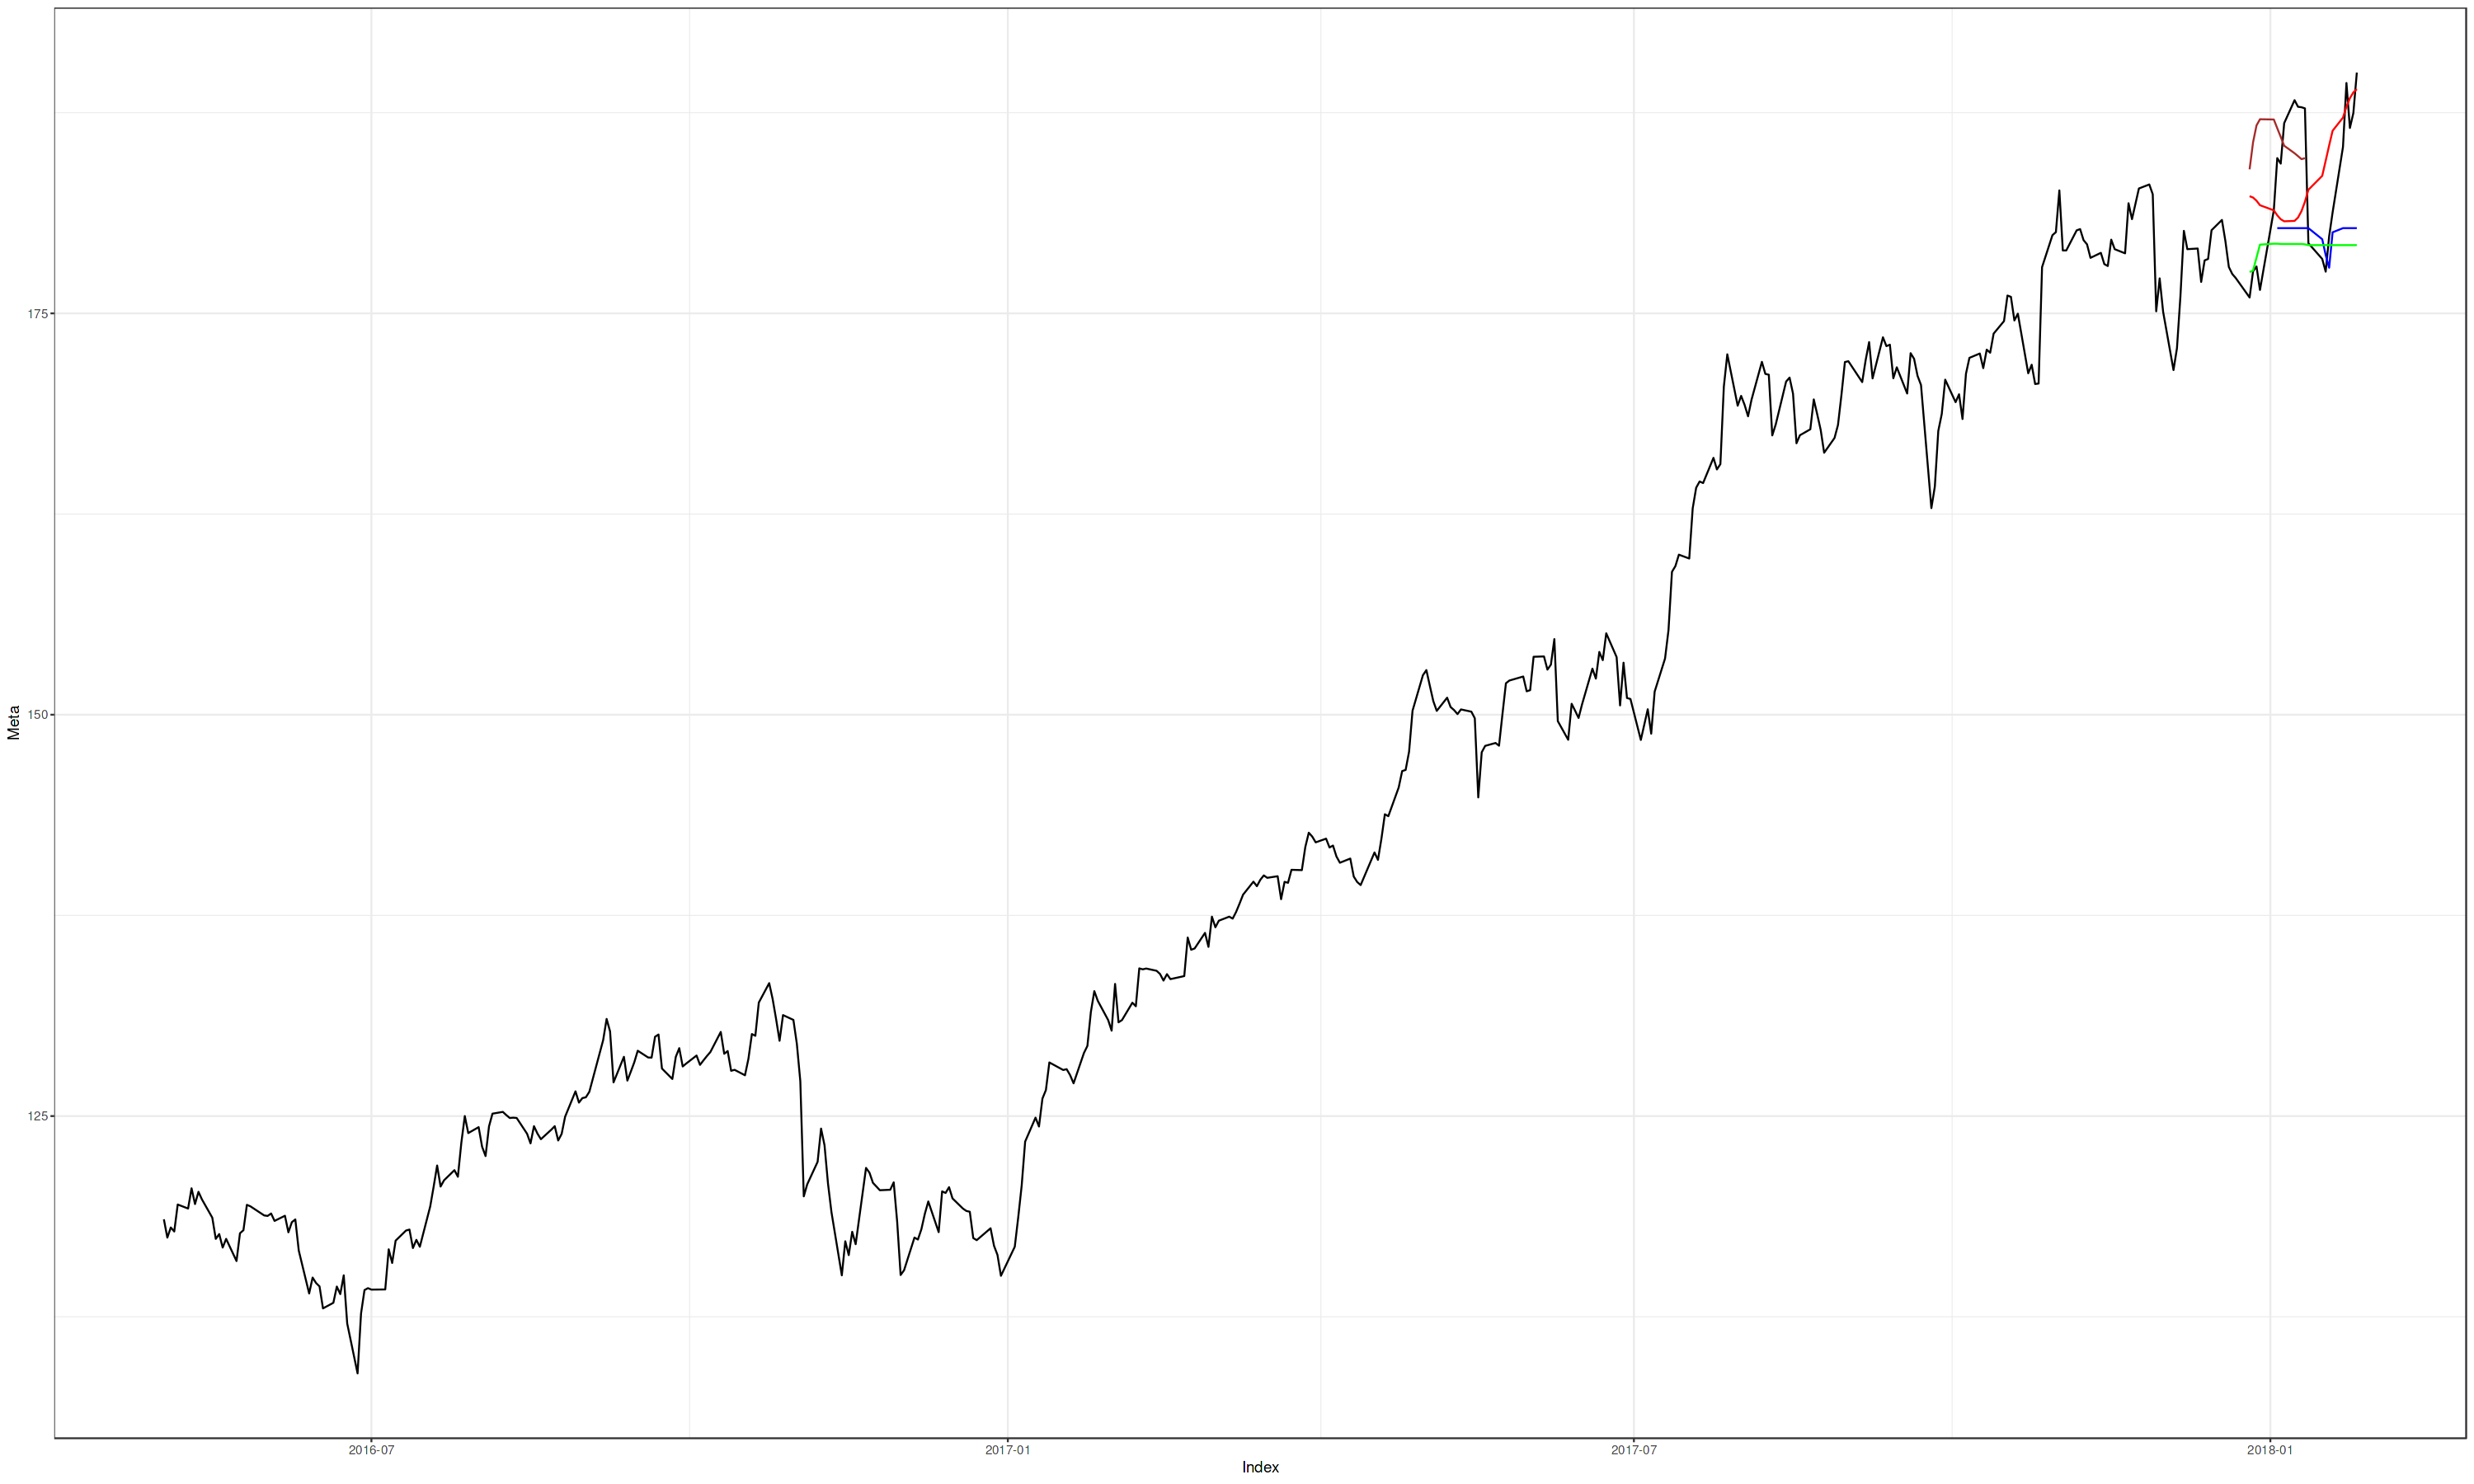

In [ ]:
library(repr)
options(repr.plot.width=25, repr.plot.height=15) #
Pr_index %>%
  ggplot(aes(Index)) +
  geom_line(aes(y = Meta), color = "black") +
  geom_line(aes(y = PredMars), data = y_test, color = "blue") +
   geom_line(aes(y = PredRF), data = data_df_ts, color = "green") +
 geom_line(aes(y = PredSSA), data = data_df_ts, color = "red") +
geom_line(aes(y = PredLSTM), data = data_data_LSTM_df_ts, color = "brown")+
  labs(color = "Serie")

In [ ]:
yardstick::metrics(y_test, truth = Meta, estimate = PredMars)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.9969888
rsq,standard,0.4373124
mae,standard,5.2377710
